#Simpsons characters classification 

Jorge Andrés Facundo Solarte 

##Setup

In [2]:

import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub


##Download the classifier and dataset repository

In [3]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [4]:
! git clone 'https://github.com/facundo1220/Simpsons_characters_classification.git'

Cloning into 'Simpsons_characters_classification'...
remote: Enumerating objects: 20982, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 20982 (delta 1), reused 9 (delta 1), pack-reused 20973
Receiving objects: 100% (20982/20982), 505.85 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (20934/20934), done.


##Image and class configuration

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))])

IMAGE_SHAPE+(3,)

(224, 224, 3)

In [6]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('/content/Simpsons_characters_classification/simpsons_dataset', target_size=IMAGE_SHAPE)

Found 20933 images belonging to 42 classes.


In [7]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 42)


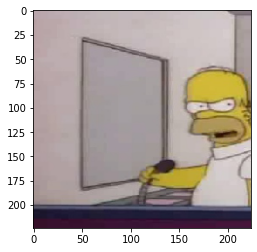

In [8]:
plt.imshow(image_batch[7])

##Download and edit the headless model

In [9]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [10]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [11]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


##Attach a classification head

In [12]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 42)                53802     
                                                                 
Total params: 2,311,786
Trainable params: 53,802
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
predictions = model(image_batch)

In [14]:
predictions.shape

TensorShape([32, 42])

##Train the model

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [17]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/5
655/655 [==============================] - 83s 121ms/step - loss: 1.2954 - acc: 0.5938
Epoch 2/5
655/655 [==============================] - 78s 119ms/step - loss: 0.8675 - acc: 0.7500
Epoch 3/5
655/655 [==============================] - 79s 120ms/step - loss: 1.2014 - acc: 0.6875
Epoch 4/5
655/655 [==============================] - 79s 120ms/step - loss: 0.8867 - acc: 0.7500
Epoch 5/5
655/655 [==============================] - 79s 121ms/step - loss: 0.5455 - acc: 0.8125


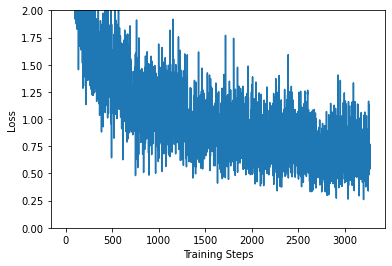

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

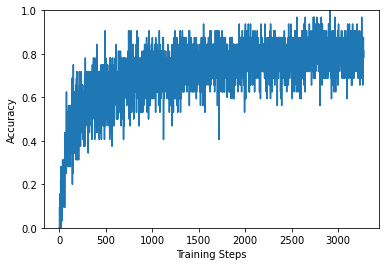

In [19]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Check the predictions

In [20]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Abraham_Grampa_Simpson', 'Agnes_Skinner',
       'Apu_Nahasapeemapetilon', 'Barney_Gumble', 'Bart_Simpson',
       'Carl_Carlson', 'Charles_Montgomery_Burns', 'Chief_Wiggum',
       'Cletus_Spuckler', 'Comic_Book_Guy', 'Disco_Stu', 'Edna_Krabappel',
       'Fat_Tony', 'Gil', 'Groundskeeper_Willie', 'Homer_Simpson',
       'Kent_Brockman', 'Krusty_The_Clown', 'Lenny_Leonard',
       'Lionel_Hutz', 'Lisa_Simpson', 'Maggie_Simpson', 'Marge_Simpson',
       'Martin_Prince', 'Mayor_Quimby', 'Milhouse_Van_Houten',
       'Miss_Hoover', 'Moe_Szyslak', 'Ned_Flanders', 'Nelson_Muntz',
       'Otto_Mann', 'Patty_Bouvier', 'Principal_Skinner',
       'Professor_John_Frink', 'Rainier_Wolfcastle', 'Ralph_Wiggum',
       'Selma_Bouvier', 'Sideshow_Bob', 'Sideshow_Mel', 'Snake_Jailbird',
       'Troy_Mcclure', 'Waylon_Smithers'], dtype='<U24')

In [21]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [22]:
label_id = np.argmax(label_batch, axis=-1)

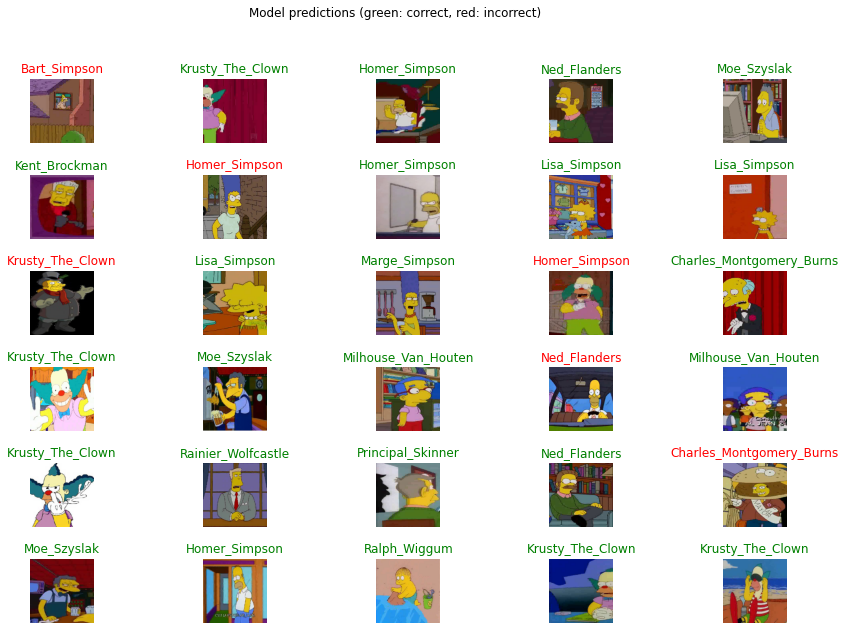

In [24]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export the model

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

##Test exported model

In [ ]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)

reloaded_result_batch = reloaded.predict(image_batch)

reloaded_predicted_id = np.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]

In [30]:
reloaded_label_id = np.argmax(label_batch, axis=-1)

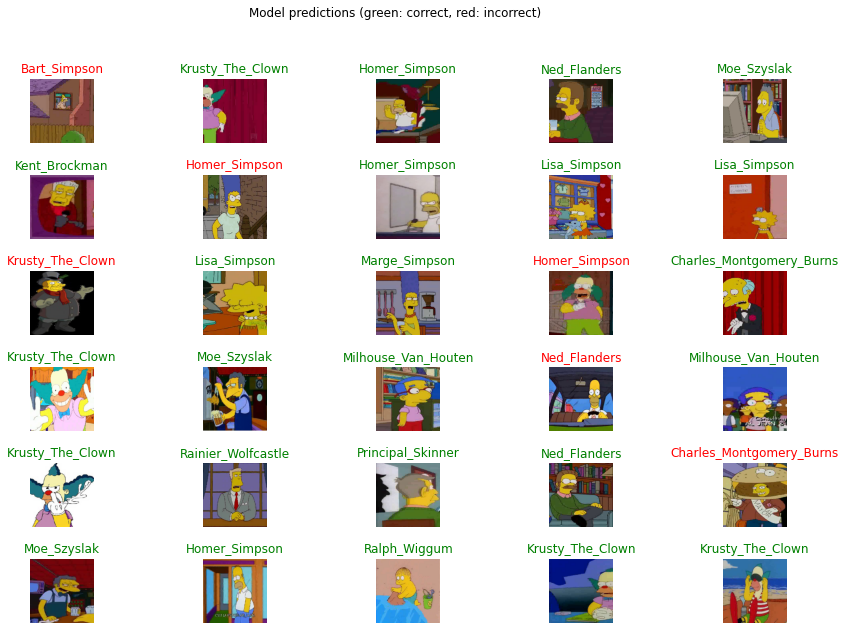

In [32]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if reloaded_predicted_id[n] == reloaded_label_id[n] else "red"
  plt.title(reloaded_predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")